# Mesa Schelling example - Schelling Segregation Model

[[Code explanation]](https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a) **Note that the final interactive visualization part is optional**

## Description

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a more happier grid space (if available). While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

## Sample Model Description

The tutorial model is a very simple simulated agent segregation. The rules of our tutorial model:

1. There are some number of agents.
2. All agents begin as randomly placed on a grid.
3. At every step of the model, an agent considers his surrounding neighbors to be of the same type in order for them to be happy.
4. If an agent is unhappy, it moves the the unoccupied cell with maximal happines (if such happines is at least equal to the one at the current location); otherwise, an agent doesn't move

Despite its simplicity, this model yields results that are often unexpected to those not familiar with it. For our purposes, it also easily demonstrates Mesa’s core features.

## How to use and modify the code

These excercises are designed around a Mesa template that is given to you to reuse. You are not asked to perform any complex object programming, but instead we ask for understanding of the core features of the Mesa pyhton package. You will mostly have to modifly the existing template and code the ``Model`` and ``Agent``behavior using standard python code.

**Therefore, in this excercise, you are asked to fill your code where the comments state:**

``#[Your code here]``

Let’s get started.

# 1. Create the Basic Agent/Model

## Setting up the model

To begin writing the model code, we start with two core classes: one for
the overall model, the other for the agents. The model class holds the
model-level attributes, manages the agents, and generally handles the
global level of our model. Each instantiation of the model class will be
a specific model run. Each model will contain multiple agents, all of
which are instantiations of the agent class. Both the model and agent
classes are child classes of Mesa’s generic ``Model`` and ``Agent``
classes.

### At the location ``# 1 Initialization``:

Each agent has only two variables:
- 2D position on the grid (x , y)
- agent type [0, 1]

(Each agent will also have a unique identifier (i.e., a position), stored in
the ``pos`` variable. Giving each agent a unique id is a good
practice when doing agent-based modeling.)

### At the location ``# 2 Step agent function``:

- if there are no neighbors - agent is happy and stays

### At the location ``# 3 Calculate the number of similar neighbours``:

- calculate the number of similar neighbours
- if the Agent is happy with it's neighbourhood - it stays

### At the location ``# 4 Move to an empty location if unhappy``:

- build a happines priority list of all possible empty cells
- move to a higest happines place from such list of empties, if happines is as high as at current location

The beginning of Agent class looks like this:

In [1]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid

In [2]:
class SchellingAgentBasic(Agent):
    
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.

         Args:
            pos: Agent initial location and unique identifier for the agent.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        
        super().__init__(pos, model)
        
        # 1 Initialization
        
        self.pos = pos
        self.type = agent_type
        
    def step(self):
        '''
        Run one step of the agent. Move if unhappy, stay otherwise
        '''
        
        # 2 Step agent function
        
        n_neighbors = len(self.model.grid.get_neighbors(self.pos, True))
        
        # if there are no neighbors - agent is happy and stays
        if n_neighbors == 0:
            self.model.happy += 1
            return
        
        # 3 Calculate the number of similar neighbours  
        similar_neighbors = 0
        neighbors = self.model.grid.iter_neighbors(self.pos, moore = True)
        
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar_neighbors += 1
                        
        # if the Agent is happy with it's neighbourhood - it stays
        loc_happines = (similar_neighbors/n_neighbors) * 100
        if loc_happines >= self.model.homophily:
            self.model.happy += 1
            return
            
        # 4 Move to an empty location if unhappy
        
        # if the Agent is unhappy - perform move to better empty cell
        empty_happines_list = {}
        for empty in self.model.grid.empties:
            
            similar = 0
            empty_neighbors = self.model.grid.iter_neighbors(empty, moore = True)
            for neighbor in empty_neighbors:
                if neighbor.type == self.type:
                    similar += 1
                    
            # build a happines priority list of all possible empty cells
            n_empty_neighbors = len(self.model.grid.get_neighbors(empty, True))
            empty_loc_happines = (similar / n_empty_neighbors) * 100
            
            empty_happines_list[empty] = empty_loc_happines
            
        # move to a higest happines place from such list of empties, if happines is as high as at current location
        if empty_happines_list:
            max_happines_empty_loc = max(empty_happines_list, key=empty_happines_list.get)
            
            if empty_happines_list[max_happines_empty_loc] >= loc_happines:
                self.model.grid.move_agent(self, max_happines_empty_loc)


## Adding the scheduler

Time in most agent-based models moves in steps, sometimes also called
**ticks**. At each step of the model, one or more of the agents –
usually all of them – are activated and take their own step, changing
internally and/or interacting with one another or the environment.

The **scheduler** is a special model component which controls the order
in which agents are activated. For example, all the agents may activate
in the same order every step; their order might be shuffled; we may try
to simulate all the agents acting at the same time; and more. Mesa
offers a few different built-in scheduler classes, with a common
interface. That makes it easy to change the activation regime a given
model uses, and see whether it changes the model behavior. This may not
seem important, but scheduling patterns can have an impact on your
results.

For now, let’s use one of the simplest ones: ``RandomActivation``, which
activates all the agents once per step, in random order. Every agent is
expected to have a ``step`` method. The step method is the action the
agent takes when it is activated by the model schedule. We add an agent
to the schedule using the ``add`` method; when we call the schedule’s
``step`` method, the model shuffles the order of the agents, then
activates and executes each agent’s ``step`` method.

With that in mind, the model code with the scheduler added looks like
this:

## Adding space

Many ABMs have a spatial element, with agents moving around and
interacting with nearby neighbors. Mesa currently supports two overall
kinds of spaces: grid, and continuous. Grids are divided into cells, and
agents can only be on a particular cell, like pieces on a chess board.
Continuous space, in contrast, allows agents to have any arbitrary
position. Both grids and continuous spaces are frequently
[toroidal](https://en.wikipedia.org/wiki/Toroidal_graph), meaning
that the edges wrap around, with cells on the right edge connected to
those on the left edge, and the top to the bottom. This prevents some
cells having fewer neighbors than others, or agents being able to go off
the edge of the environment.

Let’s add a simple spatial element to our model by putting our agents on
a grid and make them walk around based on the happines and homophily tershold.

Mesa has two main types of grids: ``SingleGrid`` and ``MultiGrid``.
``SingleGrid`` enforces at most one agent per cell; ``MultiGrid`` allows
multiple agents to be in the same cell. Since we want one agent per cell, we use ``SingleGrid``.

`from mesa.space import SingleGrid`

We instantiate a grid with width and height parameters, and a boolean as
to whether the grid is toroidal. Let’s make width and height model
parameters, in addition to the number of agents, and have the grid
always be toroidal. We can place agents on a grid with the grid’s
``place_agent`` method, which takes an agent and an (x, y) tuple of the
coordinates to place the agent.

Under the hood, each agent’s position is stored in two ways: the agent
is contained in the grid in the cell it is currently in, and the agent
has a ``pos`` variable with an (x, y) coordinate tuple. The
``place_agent`` method adds the coordinate to the agent automatically.

### At the location ``# 1 Initialization``:

There are a number of model-level parameters: 

- height and width of the grid
- density of grid population to define how many agents and empty cells the model contains
- minority proportion to define proportion of two types of agents on the grid
- homophily treshold to which the agent is happy with its neighbourhood
- Use ``RandomActivation`` scheduler
- Use ``SingleGrid`` space with torus folding

**Hint:** Note that homophily treshold should be defined as the ratio of similar neighbours (e.g. 30% of similar agents), instead of a fixed number of neighbouring agents (3 similar agents). The problem of fixed number lies in the possibility of empty cells in the neighbourood, which might reduce the total number of neighbours from 8 possible neighbours, to a lower total number of neighbours. Consider an example where an agent requires 3 similar agents as neigbours (Case 1 - majority: 3 similar + 2 other = 5 neighbours/3 empty spaces; Case2 - balanced: 3 similar + 3 other = 6 neighbours/3 empty spaces; Case 3 - minority: 3 similar + 5 other = 8 neighbours/0 empty spaces). Using the ratio of similar neighbours of all neighbours solves this issue.

### At the location ``# 2 Create agents``:

- use uniform random numbers to populate the grid based on density parameter
- use uniform random numbers to selects agent type based on minority proportion

When a new model is started, we want it to populate the grid itself with the defined number of agents segregated on the given proportion between two groups.

In [3]:
class SchellingModelBasic(Model):

    def __init__(self, height, width, density, minority_pc, homophily):
        '''
        Create a new Schelling model.

         Args:
            width: Horizontal axis of the grid which is used together with Height to define the total number of agents in the system.
            height: Vertical axis of the grid which is used together with Width to define the total number of agents in the system.
            density: Define the population density of agent in the system. Floating value from 0 to 1.
            fraction minority: The ratio between blue and red. Blue is represented as the minority while red is represented as the majority. Floating value from 0 to 1. If the value is higher than 0.5, blue will become the majority instead.
            homophily: Define the number of similar neighbors required for the agents to be happy. Integer value range from 0 to 100 representing percentage
        '''
        super().__init__()
        
        # 1 Initialization [Your code here]
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.running = True
        
        # 2 Create agents
        
        # We use a grid iterator that returns the coordinates of a cell as well as its contents. (coord_iter)
        for cell, coordinates in self.grid.coord_iter():
            x = coordinates[0]
            y = coordinates[1]
            
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgentBasic((x, y), self, agent_type)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        # 3 Step model function

        # Reset counter of happy agents each model step
        self.happy = 0
        self.schedule.step()
        
        # 4 Stop the model if all agents are happy
        if self.happy == self.schedule.get_agent_count():
            self.running = False

# 2. Run the Agent/Model Basic

### Running the model

At this point, we have a model which runs.
You can see for yourself with a few easy lines. If you’ve been working
in an interactive session, you can create a model object directly. 

With that last piece in hand, it’s time for the first rudimentary run of
the model.

Now let’s create a model with 20 x 20 agents, and run it for 100 steps.

### At the location ``# Model parameters``:

- specify all model-level parameters of its __init__ function
- height and width are given already as 20 x 20, as well as density and minority proportion
- given: homophily treshold of 20%

In [4]:
# Model parameters
model = SchellingModelBasic(20, 20, 0.98, 0.5, 20)

while model.running and model.schedule.steps < 100:
    model.step()
                            
print('The Schelling Model ran for {} steps'.format(model.schedule.steps))

The Schelling Model ran for 100 steps


/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 0) is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 1) is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 2) is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 3) is being placed with
place_agent() despite already having the 

# 3. Visualize the Agent/Model

### At the location ``# Model parameters``:

- specify all model-level parameters of its __init__ function
- height and width are given already as 20 x 20, as well as density and minority proportion
- given: homophily treshold 20%

In [5]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    
    # 1 Color the agents based on their type to Red and Blue color
    if agent.type == 0:
        portrayal["Color"] = "Red"
    else:
        portrayal["Color"] = "Blue"
        
    return portrayal

grid = CanvasGrid(agent_portrayal, 20, 20, 500, 500)
server = ModularServer(SchellingModelBasic,
                       [grid],
                       "Schelling Model",
                       {"width":20, "height":20, "density":0.98, "minority_pc":0.5, "homophily":20}) # Model parameters

/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 0) is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 1) is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 2) is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 4) is being placed with
place_agent() despite already having the 

# 4. Run the Agent/Model Visualization

NOTE: Runtime server error is normal and expected when running visualization code below. This visualization code was made for command line execution (not explicitly for Jupyter Notebooks), so we are **forcing** it's use.

Just make sure to increment the port number counter each visualization run, to be able to use it.

In [7]:
server.port = 8521 # The default 8521 - increase the counter as you run the visalizations
server.launch() # Uncomment to run the visalization

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}


/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 0) is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 1) is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 2) is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
/tmp/ipykernel_17467/3263871375.py:44: UserWarning: Agent (0, 3) is being placed with
place_agent() despite already having the position (0, 3). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}


# 5. Collect data to Analyze the Agent/Model

### Collecting Data

So far, at the end of every model run, we’ve had to go and write our own
code to get the data out of the model. This has two problems: it isn’t
very efficient, and it only gives us end results. If we wanted to know
the wealth of each agent at each step, we’d have to add that to the loop
of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data
for analysis, Mesa provides a class which can handle data collection and
storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level
variables, agent-level variables, and tables (which are a catch-all for
everything else). Model- and agent-level variables are added to the data
collector along with a function for collecting them. Model-level
collection functions take a model object as an input, while agent-level
collection functions take an agent object as an input. Both then return
a value computed from the model or each agent at their current state.
When the data collector’s ``collect`` method is called, with a model
object as its argument, it applies each model-level collection function
to the model, and stores the results in a dictionary, associating the
current value with the current step of the model. Similarly, the method
applies each agent-level collection function to each agent currently in
the schedule, associating the resulting value with the step of the
model, and the agent’s ``unique_id``.

Let’s add a DataCollector to the model, and collect two variables. At
the agent level, we want to collect every agent’s position at every step.
At the model level, let’s measure the model’s [Moran's I](https://en.wikipedia.org/wiki/Moran%27s_I), a
measure of spatial autocorrelation.

At the last step of the model, the datacollector will collect and store the
model-level Moran's I coefficient, as well as each agent’s position,
associating each with the last step.

### # 4. Analysis code for calculating Moran's I

- note that this is the code for calculation of Moran's I

### Agent code should be the same (copy the code above)

### Model code has a ``DataCollector`` step

- note the use of ``DataCollector`` to collect the following model-level data:
- number of happy agents
- Moran's I

In [8]:
def get_morans_i(model):
    '''
    Find Moran's I for all agents and neighbours on the grid.
    '''
    
    x_kappa = model.minority_pc
    N = model.schedule.get_agent_count()
    edges_var = 0
    edges_sum = 0
    total_edges = 0
    
    # 4. Analysis code for calculating Moran's I
    
    for agent in model.schedule.agents:
        edges_var += (agent.type - x_kappa) ** 2
        for neighbor in model.grid.iter_neighbors(agent.pos, moore = True):
            total_edges += 1
            edges_sum += (agent.type - x_kappa) * (neighbor.type - x_kappa)
            
    return (N * edges_sum) / (total_edges * edges_var)


In [9]:
class SchellingAgentAnalysis(Agent):
    
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.

         Args:
            pos: Agent initial location and unique identifier for the agent.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        
        super().__init__(pos, model)
        
        # 1 Initialization
        
        self.pos = pos
        self.type = agent_type
        
    def step(self):
        '''
        Run one step of the agent. Move if unhappy, stay otherwise
        '''
        
        # 2 Step agent function
        
        n_neighbors = len(self.model.grid.get_neighbors(self.pos, True))

        # 3 Calculate the number of similar neighbours
        
        # if there are no neighbors - agent is happy and stays
        if n_neighbors == 0:
            self.model.happy += 1
            return
        
        similar_neighbors = 0
        neighbors = self.model.grid.iter_neighbors(self.pos, moore = True)
            
        # calculate the number of similar neighbours
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar_neighbors += 1
                        
        # if the Agent is happy with it's neighbourhood - it stays
        loc_happines = (similar_neighbors/n_neighbors) * 100
        if loc_happines >= self.model.homophily:
            self.model.happy += 1
            return
            
        # 4 Move to an empty location if unhappy
        
        # if the Agent is unhappy - perform move to better empty cell
        empty_happines_list = {}
        for empty in self.model.grid.empties:
            
            n_empty_neighbors = len(self.model.grid.get_neighbors(empty, True))
            
            similar = 0
            empty_neighbors = self.model.grid.iter_neighbors(empty, moore = True)
            
            for neighbor in empty_neighbors:
                if neighbor.type == self.type:
                    similar += 1
                    
            # build a happines priority list of all possible empty cells
            empty_loc_happines = (similar / n_empty_neighbors) * 100
            empty_happines_list[empty] = empty_loc_happines
            
        # move to a higest happines place from such list of empties, if happines is as high as at current location
        if empty_happines_list:
            max_happines_empty_loc = max(empty_happines_list, key=empty_happines_list.get)

            if empty_happines_list[max_happines_empty_loc] >= loc_happines:
                self.model.grid.move_agent(self, max_happines_empty_loc)

In [10]:
from mesa.datacollection import DataCollector

class SchellingModelAnalysis(Model):

    def __init__(self, height, width, density, minority_pc, homophily):
        '''
        Create a new Schelling model.

         Args:
            width: Horizontal axis of the grid which is used together with Height to define the total number of agents in the system.
            height: Vertical axis of the grid which is used together with Width to define the total number of agents in the system.
            density: Define the population density of agent in the system. Floating value from 0 to 1.
            fraction minority: The ratio between blue and red. Blue is represented as the minority while red is represented as the majority. Floating value from 0 to 1. If the value is higher than 0.5, blue will become the majority instead.
            homophily: Define the number of similar neighbors required for the agents to be happy. Integer value range from 0 to 8 since you can only be surrounded by 8 neighbors.
        '''
        super().__init__()
        
        # 1 Initialization [Your code here]
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        
        # Collect data
        self.datacollector = DataCollector(
            {"Happy": "happy", "Morans_I": get_morans_i},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})
        
        self.running = True
        
        # 2 Create agents
        
        # We use a grid iterator that returns the coordinates of a cell as well as its contents. (coord_iter)
        for cell, coordinates in self.grid.coord_iter():
            x = coordinates[0]
            y = coordinates[1]
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgentAnalysis((x, y), self, agent_type)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        # 3 Step model function

        # Reset counter of happy agents each model step
        self.happy = 0
        self.schedule.step()
        
        # 2 collect data
        self.datacollector.collect(self)
        
        # 4 Stop the model if all agents are happy
        if self.happy == self.schedule.get_agent_count():
            self.running = False

### Running the model

We run the model just as we did above. Now is when an interactive
session, especially via a Notebook, comes in handy: the DataCollector
can export the data it’s collected as a pandas DataFrame, for easy
interactive analysis.

Now we instantiate a model instance: a 20x20 grid, with an 98% chance of an agent being placed in each cell, approximately 50% of agents set as minorities, and agents wanting at least 20% similar neighbors.

We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

### At the location ``# Model parameters``:

- specify all model-level parameters of its __init__ function
- height and width are given already as 20 x 20, as well as density and minority proportion
- given: homophily treshold of 20%

In [11]:
# Model parameters
model = SchellingModelAnalysis(20, 20, 0.98, 0.5, 20)
                            
while model.running and model.schedule.steps < 100:
    model.step()

print('The Schelling Model ran for {} steps'.format(model.schedule.steps))

The Schelling Model ran for 3 steps


/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 0) is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 1) is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 2) is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 3) is being placed with
place_agent() despite already having the 

# 6. Run the Agent/Model Analysis

Now we can get the agent-position data

**It is always a good practice to validate (debug) your model with visualizing agents behavior.**

You’ll see that the DataFrame’s index is pairings of model step and agent ID. You can analyze it the way you would any other DataFrame.

In [12]:
import pandas as pd

agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out.head()

x   y
Step AgentID         
1    (4, 15)    4  15
     (15, 7)   15   7
     (12, 15)  12  15
     (3, 14)    3  14
     (15, 18)  15  18

<Axes: xlabel='Step'>

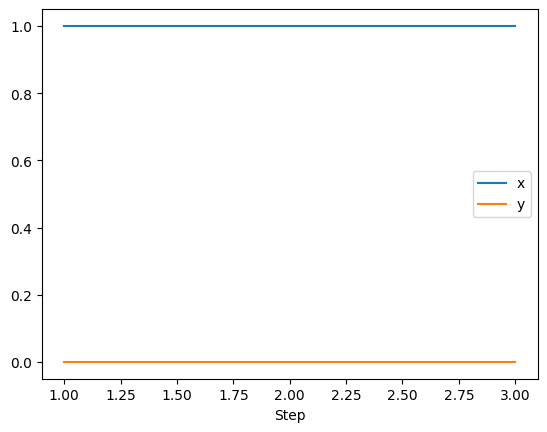

In [13]:
agent_out.xs((1,0), level="AgentID").plot(y=["x", "y"]) # Create a plot for the x, y position of a single agent over the model steps

Similarly, we can get the model-moran's I data.

In [14]:
import pandas as pd

model_out = model.datacollector.get_model_vars_dataframe()
model_out.head()

,Happy,Morans_I
0,372,0.147389
1,388,0.155321
2,389,0.155321


<Axes: >

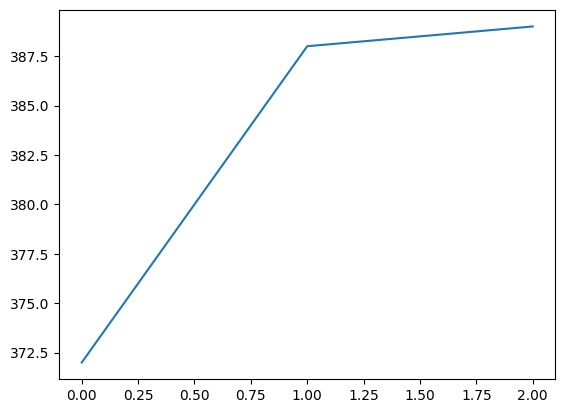

In [15]:
# Create a plot for the number of happy agents over the model steps
model_out.Happy.plot()

# 7. Create iteration Batch of the Agent/Model

### Batch Run

Like we mentioned above, you usually won’t run a model only once, but
multiple times, with fixed parameters to find the overall distributions
the model generates, and with varying parameters to analyze how they
drive the model’s outputs and behaviors. Instead of needing to write
nested for-loops for each model, Mesa provides a ``batch_run`` function
which automates it for you.

The batch runner also requires an additional variable ``self.running``
for the Model class. This variable enables conditional shut off of
the model once a condition is met.

### At the location ``# Model parameters``:

- specify all model-level parameters of its __init__ function
- height and width are given already as 20 x 20, as well as density and minority proportion
- given: homophily treshold in rangefrom 0 to 100 in steps of 13

In [16]:
# Model parameters
params = {"height": 20, "width": 20, "density": 0.98, "minority_pc": 0.5, "homophily": range(0,100, 13)}

# 8. Run the Agent/Model Batch

### Running the model

We call ``batch_run`` with the following arguments:

* ``model_cls``

  The model class that is used for the batch run.

* ``parameters``

  A dictionary containing all the parameters of the model class and
  desired values to use for the batch run as key-value pairs. Each
  value can either be fixed ( e.g. ``{"height": 10, "width": 10}``)
  or an iterable (e.g. ``{"homophily": range(0,100, 13)}``). ``batch_run``
  will then generate all possible parameter combinations based on this
  dictionary and run the model ``iterations`` times for each combination.

* ``number_processes``

  Number of processors used to run the sweep in parallel. Optional.
  If not specified, defaults to use all the available processors.

  Note: Multiprocessing does make debugging challenging. If your
  parameter sweeps are resulting in unexpected errors set ``number_processes = 1``.
  
  Also, if your batcher is stuck and is not running for some reason, try also setting ``number_processes = 1``, since this issue might also be related to multiprocessing issues.

* ``iterations``

  The number of iterations to run each parameter combination for. Optional.
  If not specified, defaults to 1.

* ``data_collection_period``

  The length of the period (number of steps) after which the model and
  agent reporters collect data. Optional. If not specified, defaults to -1,
  i.e. only at the end of each episode.

* ``max_steps``

  The maximum number of time steps after which the model halts. An episode
  does either end when ``self.running`` of the model class is set to
  ``False`` or when ``model.schedule.steps == max_steps`` is reached.
  Optional. If not specified, defaults to 1000.

* ``display_progress``

  Display the batch run progress. Optional. If not specified, defaults to ``True``.

In the following example, we hold the height and width fixed, and vary
the homophily treshold of agents. We tell the batch runner to run 10 instantiations
of the model with each number of agents, and to run each for 200 steps.

We want to keep track of

1. the Moran's I coefficient value and
2. the individual agent’s position development.

In [17]:
# If your batcher is stuck and is not running for some reason, try setting number_processes = 1

from mesa.batchrunner import batch_run

results = batch_run(
    SchellingModelAnalysis,
    parameters=params,
    iterations=10,
    max_steps=100,
    number_processes=1,
    data_collection_period=-1,
    display_progress=True,
)

  0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 0) is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 1) is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 2) is being placed with
place_agent() despite already having the position (0, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/tmp/ipykernel_17467/3879513174.py:52: UserWarning: Agent (0, 3) is being placed with
place_agent() despite already having the 

# 9. Run the Batch data Analysis

### Data visualization

First, we want to take a closer look at how the Moran's I coefficient at the
end of each episode changes as we increase the homophily treshold of the population.
For this, we group our data on the ``RunId`` identifier and get a single value per ``RunId`` using a median. Our results to only contain the data of Moran's I for the entire population at the final step of each episode and then box-plot the values
for the Moran's I coefficient over the the hoophily of agents. Notice there are
10 values for each homophily treshold since we set ``iterations=10`` when
calling the batch run.

In [18]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.head()

,RunId,iteration,Step,height,width,density,minority_pc,homophily,Happy,Morans_I,AgentID,x,y
0,0,0,0,20,20,0.98,0.5,0,389,-0.033708,NaN,NaN,NaN
1,1,0,2,20,20,0.98,0.5,13,389,0.082011,"(19, 14)",19.0,14.0
2,1,0,2,20,20,0.98,0.5,13,389,0.082011,"(10, 16)",10.0,16.0
3,1,0,2,20,20,0.98,0.5,13,389,0.082011,"(11, 12)",11.0,12.0
4,1,0,2,20,20,0.98,0.5,13,389,0.082011,"(10, 1)",10.0,1.0


In [19]:
results_df.groupby(by=["RunId", "iteration", "Step"]).median()

/tmp/ipykernel_17467/626563551.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby(by=["RunId", "iteration", "Step"]).median()


,,,height,width,density,minority_pc,homophily,Happy,Morans_I,x,y
RunId,iteration,Step,,,,,,,,,
0,0,0,20.0,20.0,0.98,0.5,0.0,389.0,-0.033708,NaN,NaN
1,0,2,20.0,20.0,0.98,0.5,13.0,389.0,0.082011,10.0,9.0
2,0,3,20.0,20.0,0.98,0.5,26.0,388.0,0.503989,10.0,10.0
3,0,6,20.0,20.0,0.98,0.5,39.0,394.0,0.649485,10.0,9.0
4,0,100,20.0,20.0,0.98,0.5,52.0,383.0,0.769478,9.5,10.0
...,...,...,...,...,...,...,...,...,...,...,...
75,9,6,20.0,20.0,0.98,0.5,39.0,396.0,0.750000,9.0,9.0
76,9,70,20.0,20.0,0.98,0.5,52.0,395.0,0.865385,9.0,10.0
77,9,100,20.0,20.0,0.98,0.5,65.0,339.0,0.838542,10.0,10.0


Task: Find out how homophily (level of neighbour similaritly) influences the final segragation of agents using the mean or box plot. You should be able to plot the average outcome for each homophily value.

**hint** Your plot should look similar to [this paper](https://www.jasss.org/15/1/6.html). Not neccesarily with Moran's I, but the transition should be visible

### Create a box-plot for the Moran's I over the homophily tresholds

- plot the boxplot of Moran's I values over homophiliy treshold values from models data you collected
- using the Pandas ``.boxplot()`` method
- group Moran's I values by ``homophily``
- plot the ``Morans_I`` column

/tmp/ipykernel_17467/3070234478.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby(by=["RunId"]).median().boxplot(by ='homophily', column =['Morans_I'], grid=False, rot=45)


<Axes: title={'center': 'Morans_I'}, xlabel='homophily'>

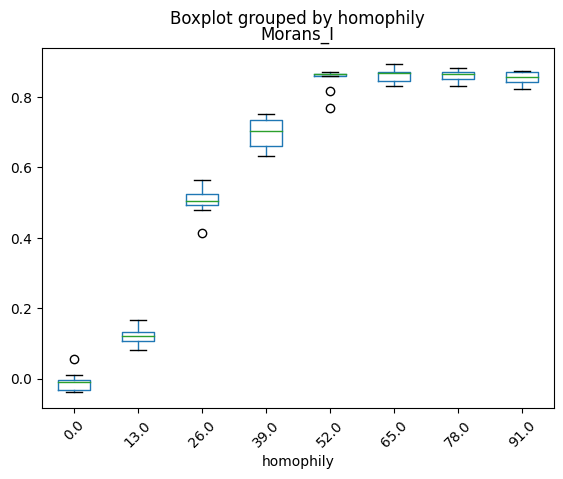

In [20]:
# Create a box-plot for the Moran's I over the homophily tresholds
results_df.groupby(by=["RunId"]).median().boxplot(by ='homophily', column =['Morans_I'], grid=False, rot=45)

# Appendix

## Visualize the Agent/Model - interactive advanced

In [ ]:
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization import Slider

class HappyElement(TextElement):
    '''
    Display a text count of how many happy agents there are.
    '''

    def render(self, model):
        return "Happy agents: " + str(model.happy)

def agent_portrayal(agent):
    '''
    Portrayal Method for canvas
    '''
    if agent is None:
        return
    portrayal = {"Shape": "circle", "r": 0.5, "Filled": "true", "Layer": 0}

    if agent.type == 0:
        portrayal["Color"] = "Red"
    else:
        portrayal["Color"] = "Blue"
        
    return portrayal

happy_element = HappyElement()
canvas_element = CanvasGrid(agent_portrayal, 20, 20, 500, 500)
chart = ChartModule([{"Label": "Morans_I", "Color": "Black"}], data_collector_name="datacollector")

model_params = {
    
    "width":20, 
    "height":20,
    "density": Slider(
        "percentage of occupied cells",
        0.98,
        0,  
        1,
        0.01    
    ), 
    "minority_pc": Slider(
        "ratio of agents",
        0.5,
        0,  
        1,
        0.01    
    ), 
    "homophily": Slider(
        "homophily threshold",
        20,
        0,  
        100 ,
        1    
    )
}

server = ModularServer(SchellingModelAnalysis,
                       [canvas_element,happy_element, chart],
                       "Schelling’s Segregation Model",
                       model_params)

In [ ]:
server.port = 8521 # The default
#server.launch()